In [1]:
import os
import shutil
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import dask
import util

# Load Data

In [2]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP','Jint_100m_DIC']]
ds_djf

<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time           (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables:
    SST            (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf       (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP            (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 3, 1, 93, 320), meta=np.ndarray>
    Jint_100m_DIC  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [3]:
%%time
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
ds_ctrl_mean

CPU times: user 6.87 s, sys: 4.67 s, total: 11.5 s
Wall time: 9.88 s


<xarray.Dataset>
Dimensions:        (length: 3, nlat: 93, nlon: 320)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
    TAREA          (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13
    TLAT           (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG          (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    KMT            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    ULONG          (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    ULAT           (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
Dimensions without coordinates: nlat, nlon
Data variables:
    SST            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 23.04 22.99 22.96
    Chl_surf       (nlat, nlon) float64 0.0 0.0 0.0 ... 0.1035 0.1016 0.09941
    KGP            (length, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Jint_100m_DIC  (nlat, nlon) float64 0.0 0.0 0.0 ... -0.006057 -0.00567

Standard deviation of anomalies

In [4]:
%%time
ds_ctrl_std = ( #data - mean of ref time
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id']) #take it's standard deviation
        .compute() #compute it
)
ds_ctrl_std

CPU times: user 42.3 s, sys: 2min 37s, total: 3min 19s
Wall time: 5min 41s


<xarray.Dataset>
Dimensions:        (length: 3, nlat: 93, nlon: 320)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
    TAREA          (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13
    TLAT           (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TLONG          (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    KMT            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    ULONG          (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    ULAT           (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
Dimensions without coordinates: nlat, nlon
Data variables:
    SST            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.4305 0.4294 0.4313
    Chl_surf       (nlat, nlon) float64 0.0 0.0 0.0 ... 0.003036 0.003102
    KGP            (length, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Jint_100m_DIC  (nlat, nlon) float64 0.0 0.0 0.0 ... 0.0008582 0.000823

## Compute the sign of the forced trend

In [7]:
%%time
ds_trend_sign = xr.where(
    ds_djf.sel(time=slice(2091, 2100)).mean(['time', 'member_id']) >= ds_ctrl_mean, 1., -1
).compute()
ds_trend_sign

CPU times: user 5.87 s, sys: 10.6 s, total: 16.4 s
Wall time: 16.1 s


<xarray.Dataset>
Dimensions:        (length: 3, nlat: 93, nlon: 320)
Coordinates:
    TAREA          (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13
    ULAT           (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
  * length         (length) float64 20.0 40.0 60.0
    ULONG          (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    TLONG          (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
    TLAT           (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    KMT            (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST            (nlat, nlon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Chl_surf       (nlat, nlon) float64 1.0 1.0 1.0 1.0 ... -1.0 -1.0 -1.0 -1.0
    KGP            (length, nlat, nlon) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Jint_100m_DIC  (nlat, nlon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

## Compute the value of the threshold for ToE

In [8]:
ds_toe_threshold = ds_ctrl_mean + 2. * ds_ctrl_std * ds_trend_sign
ds_toe_threshold

NameError: name 'ds_ctrl_std' is not defined

Quick plot

## Compute the time-evolving 2$\sigma$ timeseries

In [8]:
%%time
ds_2sigma = ds_djf.mean('member_id') + 2. * ds_trend_sign * ds_djf.std('member_id')
ds_2sigma = ds_2sigma.compute()
ds_2sigma

CPU times: user 1.27 s, sys: 588 ms, total: 1.86 s
Wall time: 23.1 s


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320, time: 180)
Coordinates:
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
  * length    (length) float64 20.0 40.0 60.0
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (time, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 27.12 27.05 26.99
    Chl_surf  (time, nlat, nlon) float64 0.0 0.0 0.0 ... 0.06238 0.06209 0.06176
    KGP       (time, length, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

## Identify where the 2 sigma threshold has been crossed

In [9]:
%%time
ds_x_thresh = xr.where(ds_trend_sign > 0,
               ds_2sigma > ds_toe_threshold,
               ds_2sigma < ds_toe_threshold,               
               ).compute()
ds_x_thresh

CPU times: user 91.3 ms, sys: 39.6 ms, total: 131 ms
Wall time: 125 ms


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320, time: 180)
Coordinates:
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
  * length    (length) float64 20.0 40.0 60.0
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon, time) bool False False False False ... True True True
    Chl_surf  (nlat, nlon, time) bool False False False False ... True True True
    KGP       (length, nlat, nlon, time) bool False False False ... False False

## Set up plotting

In [11]:
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar # For dealing with Colorbars the proper way - TBD in a separate PyCoffee ?
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib.ticker import FormatStrFormatter


In [12]:
# Polar Plottable
dsp = util.pop_add_cyclic(
    
    xr.Dataset({
        'kgp_std': ds_ctrl_std['KGP'].sel(length=40),
        'chl_std': ds_ctrl_std['Chl_surf'],
        'sst_std': ds_ctrl_std['SST'],
        'ncp_std': ds_ctrl_std['Jint_100m_DIC']

        'TLAT': ds_ctrl_std.TLAT.compute(),
        'TLONG': ds_ctrl_std.TLONG.compute() } ))
dsp

SyntaxError: invalid syntax (<ipython-input-12-2c24b0b77387>, line 10)

### Check things over if you want/ need:

In [ ]:
# check things out if you want
v = 'kgp_std'
dsp.[v].sel(length=40).plot()

v = 'chl_std'
dsp.[v].values.max()
dsp.[v].plot()

## Plot Standard Deviation of GP Anomoly

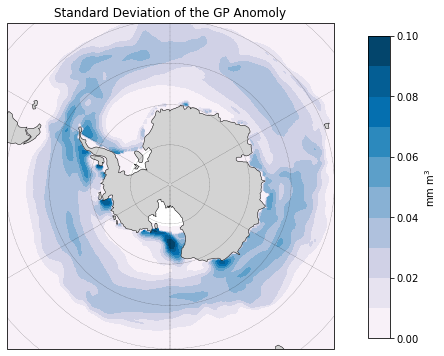

In [210]:
v = 'kgp_std'
name = 'GP-Std-Anom'
unit = 'mm m$^3$'
title = 'Standard Deviation of the GP Anomoly'

cmap='PuBu'#'cmo.matter'
levels =  np.linspace(0,.1,11)
#----------
fig = plt.figure(figsize=(6,6))
#---------- 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.contourf(dsp.TLONG, dsp.TLAT, dsp[v],
               levels = levels , cmap=cmap,
               transform=ccrs.PlateCarree())

land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
ax.set_title(f'{title}')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, 
             color='black', alpha=0.7, 
             linestyle='--').n_steps = 90  ## this makes them rounder
#----------
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label=f'{unit}')
#----------
path = 'figures/'
file = '.pdf'
plt.savefig(path + name + file, bbox_inches='tight');

## Plot Chlorophyll Standard Deviation

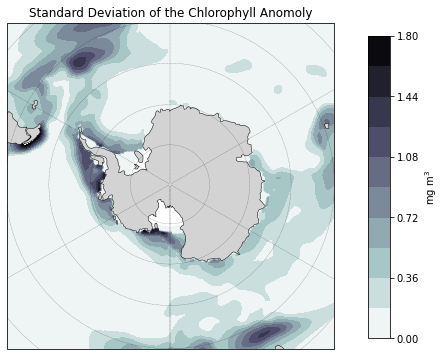

In [196]:
v = 'chl_std'
unit = 'mg m$^3$'
title = 'Standard Deviation of the Chlorophyll Anomoly'
name = 'Chl-Std-Anom'

cmap='cmo.ice_r'
cmap = 'bone_r'
levels = np.linspace(0,1.8,11)
#----------
fig = plt.figure(figsize=(6,6))
#---------- 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.contourf(dsp.TLONG, dsp.TLAT, dsp[v],
               levels = levels , cmap=cmap,
               transform=ccrs.PlateCarree())

land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
ax.set_title(f'{title}')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, 
             color='black', alpha=0.7, 
             linestyle='--').n_steps = 90  ## this makes them rounder
#----------
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label=f'{unit}')
#----------
path = 'figures/'
file = '.pdf'
plt.savefig(path + name + file, bbox_inches='tight');

## Plot SST Standard Deviation

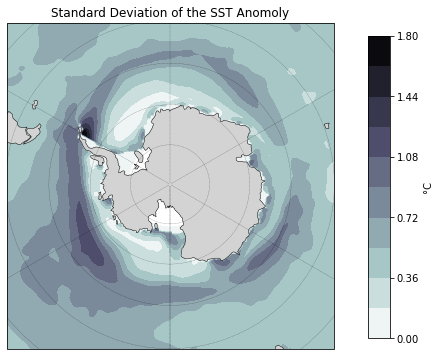

In [197]:
v = 'sst_std'
title = 'Standard Deviation of the SST Anomoly'
unit = '°C'
name = 'SST-Std-Anom'

cmap='bone_r'#'YlOrBr'#'cmo.solar_r'
levels = np.linspace(0,1.8,11)
#----------
fig = plt.figure(figsize=(6,6))
#---------- 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.contourf(dsp.TLONG, dsp.TLAT, dsp[v],
               levels = levels , cmap=cmap,
               transform=ccrs.PlateCarree())

land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
ax.set_title(f'{title}')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, 
             color='black', alpha=0.7, 
             linestyle='--').n_steps = 90  ## this makes them rounder
#----------
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label=f'{unit}')
#----------
path = 'figures/'
file = '.pdf'
#plt.savefig(path + name + file, bbox_inches='tight');

# Plot all three

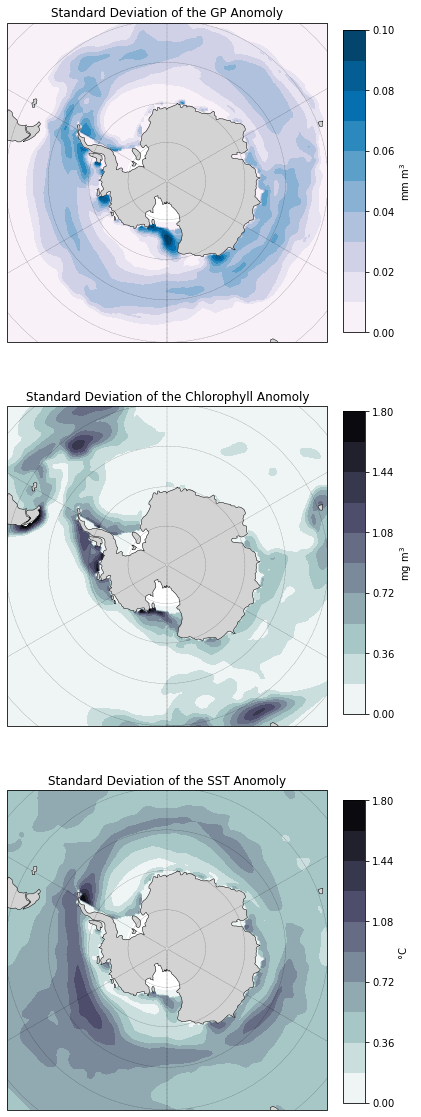

In [211]:
name = 'tri-panel-std-color'
fig = plt.figure(figsize=(6,20))
#----------
v = 'kgp_std'
title, unit = 'Standard Deviation of the GP Anomoly','mm m$^3$'
cmap= cmo.curl_r#'PuBu'#'cmo.matter'
levels =  np.linspace(0,.1,11)
#---------- 
ax = fig.add_subplot(3,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.contourf(dsp.TLONG, dsp.TLAT, dsp[v],levels = levels , cmap=cmap,
               transform=ccrs.PlateCarree())
land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
ax.set_title(f'{title}')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, color='black', alpha=0.7, 
             linestyle='--').n_steps = 90  ## this makes them rounder
#----------
cbar_ax = fig.add_axes([0.92, 0.665, 0.05, 0.21]) # xmin (lowleft), ymin(lowleft), dx (width), and dy(height) (where 0 is left/bottom and 1 is top/right). 
cbar = fig.colorbar(pc, cax=cbar_ax, label=f'{unit}')
#----------#################
v = 'chl_std'
title, unit = 'Standard Deviation of the Chlorophyll Anomoly', 'mg m$^3$'
cmap=cmo.#'bone_r'#'cmo.dense'
levels = np.linspace(0,1.8,11)
#---------- 
ax = fig.add_subplot(3,1,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.contourf(dsp.TLONG, dsp.TLAT, dsp[v],levels = levels , cmap=cmap,
               transform=ccrs.PlateCarree())
land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
ax.set_title(f'{title}')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25,color='black', alpha=0.7, 
             linestyle='--').n_steps = 90  ## this makes them rounder
#----------
cbar_ax = fig.add_axes([0.92, 0.4, 0.05, 0.21])
cbar = fig.colorbar(pc, cax=cbar_ax, label=f'{unit}')
#----------#################
v = 'sst_std'
title, unit = 'Standard Deviation of the SST Anomoly', '°C'
cmap='bone_r'#'cmo.thermal'
levels = np.linspace(0,1.8,11)
#---------- 
ax = fig.add_subplot(3,1,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.contourf(dsp.TLONG, dsp.TLAT, dsp[v],levels = levels , cmap=cmap,
               transform=ccrs.PlateCarree())
land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
ax.set_title(f'{title}')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, color='black', alpha=0.7, 
             linestyle='--').n_steps = 90  ## this makes them rounder
#----------
cbar_ax = fig.add_axes([0.92, 0.13, 0.05, 0.21])
cbar = fig.colorbar(pc, cax=cbar_ax, label=f'{unit}')
#----------
path = 'figures/'
file = '.pdf'
plt.savefig(path + name + file, bbox_inches='tight');

# Plot Total Change

In [ ]:
%%time
ds_tot_chng = ( #data - mean of ref time
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id']) #take it's standard deviation
        .compute() #compute it
)
ds_ctrl_std

In [34]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [132]:
# Polar Plottable
dsp = util.pop_add_cyclic(
    
    xr.Dataset({
        'kgp_std': ds_ctrl_std['KGP'].sel(length=40),
        'chl_std': ds_ctrl_std['Chl_surf'],
        'sst_std': ds_ctrl_std['SST'],

        'TLAT': ds_ctrl_std.TLAT.compute(),
        'TLONG': ds_ctrl_std.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:  (nlat: 93, nlon: 321)
Coordinates:
    length   float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TLONG    (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 137.2 138.3 139.4
    kgp_std  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    chl_std  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sst_std  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Plot Standard Deviation of GP Anomoly

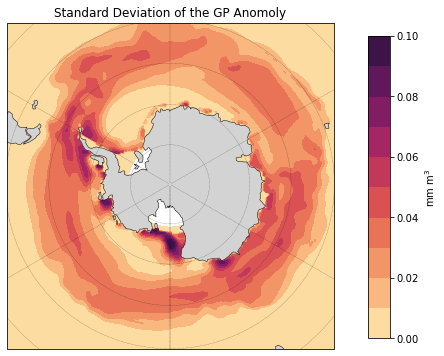

In [133]:
v = 'kgp_std'
name = 'GP-Std-Anom'
unit = 'mm m$^3$'
title = 'Standard Deviation of the GP Anomoly'

cmap='cmo.matter'
levels =  np.linspace(0,.1,11)
#----------
fig = plt.figure(figsize=(6,6))
#---------- 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.contourf(dsp.TLONG, dsp.TLAT, dsp[v],
               levels = levels , cmap=cmap,
               transform=ccrs.PlateCarree())

land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
ax.set_title(f'{title}')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, 
             color='black', alpha=0.7, 
             linestyle='--').n_steps = 90  ## this makes them rounder
#----------
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label=f'{unit}')
#----------
path = 'figures/'
file = '.pdf'
plt.savefig(path + name + file, bbox_inches='tight');

## Plot Chlorophyll Standard Deviation

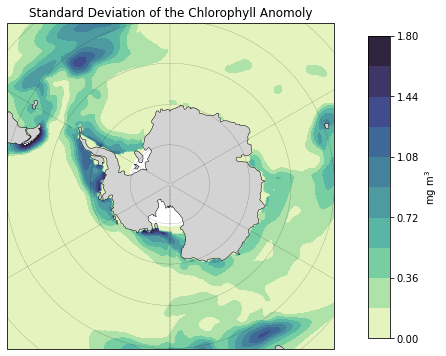

In [128]:
v = 'chl_std'
unit = 'mg m$^3$'
title = 'Standard Deviation of the Chlorophyll Anomoly'
name = 'Chl-Std-Anom'

cmap='cmo.deep'
levels = np.linspace(0,1.8,11)
#----------
fig = plt.figure(figsize=(6,6))
#---------- 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.contourf(dsp.TLONG, dsp.TLAT, dsp[v],
               levels = levels , cmap=cmap,
               transform=ccrs.PlateCarree())

land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
ax.set_title(f'{title}')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, 
             color='black', alpha=0.7, 
             linestyle='--').n_steps = 90  ## this makes them rounder
#----------
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label=f'{unit}')
#----------
path = 'figures/'
file = '.pdf'
plt.savefig(path + name + file, bbox_inches='tight');

## Plot SST Standard Deviation

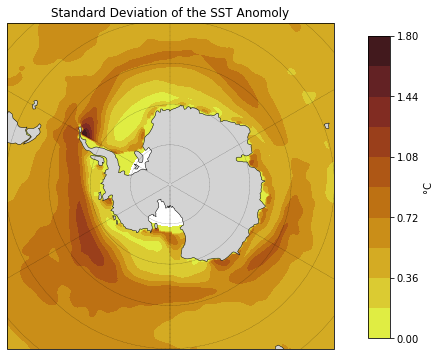

In [129]:
v = 'sst_std'
title = 'Standard Deviation of the SST Anomoly'
unit = '°C'

cmap='cmo.thermal_r'
levels = np.linspace(0,1.8,11)
#----------
fig = plt.figure(figsize=(6,6))
#---------- 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

pc=ax.contourf(dsp.TLONG, dsp.TLAT, dsp[v],
               levels = levels , cmap=cmap,
               transform=ccrs.PlateCarree())

land = ax.add_feature(
    cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
ax.set_title(f'{title}')
ax.coastlines(linewidth=0.5)
ax.gridlines(linewidth=.25, 
             color='black', alpha=0.7, 
             linestyle='--').n_steps = 90  ## this makes them rounder
#----------
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label=f'{unit}')
#----------
path = 'figures/'
file = '.pdf'
plt.savefig(path + name + file, bbox_inches='tight');